# Assignment 2B
## Logistic regression,  interactions and generalized linear mixed models (GLMM)

**In this second part of the assignment, we will see how to study binary decisions with multiple factors:**
- using **logistic regression** (one form of Generalized Linear Model) to describe how decisions depend on a set of experimental factors (and their interactions)
- using **generalized linear mixed models** (GLMM) to capture the heterogeneity of behavior across the population 

<div class="alert alert-block alert-warning">
<b>Preparing for this assignment:</b> 

The following resources will help you to get ready to complete this assignment. 
<ul>
    <li>Watch <a href="https://www.youtube.com/watch?v=yIYKR4sgzI8" target="_blank">this video</a> to have a quick overview of linear and logistic regression, a form of generalized linear regression, and how they compare. You should learn: </li>
    <ul>
        <li>what type of data is appropriate for logistic regression modeling</li>
        <li>how we can decide among candidate predictors using regression</li>
        <li>regression fit methods: least-squares versus maximum likelihood</li>
    </ul>
    <li>Watch <a href="https://www.youtube.com/watch?v=vN5cNN2-HWE" target="_blank">this video</a> in order to understand the parameters of a logistic regression:</li>
    <ul>
        <li>concept of link function (<b>logit</b> for logistic regression)</li>
        <li>how to interpret the intercept and slope parameters of predictors in a logistic regression</li>
    </ul>
    <li>Watch <a href="https://www.youtube.com/watch?v=HSHcIHMxhbE" target="_blank">this video</a> to see a step-by-step construction of a multiple linear model with interaction terms. Make sure you understand the logic of the interaction explained in the last half of the video. Take the exercise at the end of the video by stopping the video while you make your calculations.</li>
    <li>Browse <a href="https://en.wikipedia.org/wiki/Interaction_(statistics)" target="_blank">this document</a> about interactions. It focuses a lot on ANOVAs, which we do not plan to address directly, so do not focus too much on that. I suggest reading the introduction, the <i>"In regression"</i> subsection and the <i>"Examples"</i> subsection. </li>
    <li>OPTIONAL: If you were wondering why we skip ANOVAs and are happy just with linear models, ANOVA being such a popular statistical tool, <a href="https://eigenfoo.xyz/tests-as-linear/" target="_blank">here</a> is a more advanced Python document for you to make the point that linear models are a very general framework, which includes many of the classical statistical tests (also ANOVAs). We can run all our tests with linear models!!
</ul>
</div>

We will keep working on the same example as in part A of the assignment (psychometric curves).


We start by importing the typical libraries, importing the data as a dataframe and adding the relevant columns.

In [1]:
#1. Load the packages that we will need
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 2. load the data
df = pd.read_csv("https://raw.githubusercontent.com/wimmerlab/MBC-DataAnalysis/main/A2_LogisticRegression/Experiment1_all_subjects.csv")

# 3. Define a function that takes two angles as input and outputs the angular distance between the two
def circdist_deg(angles1,angles2): #define the name and set the arguments between parentheses
    angle_diff = angles2 - angles1 # simple difference
    angle_diff_rad = angle_diff*np.pi/180 # convert to radians
    angular_dist_rad = np.angle( np.exp(1j*(angle_diff_rad))) ## mathematical operation to get the circular distance (in radians)
    angular_dist = 180/np.pi*angular_dist_rad ## convert back to degrees
    output = np.round(angular_dist) # round value to eliminate numerical imprecisions (all values are integer)
    return output #return the circular distance in degrees 

# 4. Compute the displacement of the probe from the target and add it as a new column to the dataframe: 
df['displacement'] = circdist_deg( df['target'], df['probe'] );

## 1. Simple logistic regression
Logistic regression is one type of a larger family of statistical models called Generalized Linear Models (or GLMs) for binary data. Generalized Linear Models are a generalization of linear models (duh!) when the dependent variable is not a continuous variable (remember in Assignment 1 the dependent variable was an angle), for example: binary data, categorical data, count data, etc. In these cases, the assumption that observations correspond to the model plus some gaussian noise does not work. We will get back to GLMs when running regressions of spiking activity (Assignment 4).

We thus model the data using function *glm* from the *statsmodel* package, with a binomial distribution (check the Python help). The binomial distribution simply means that we are observing binary data. "GLM with binomial distribution" is almost a synonym for "logistic regression" (side note: "probit regression" is another type of "GLM with binomial distribution" which is in practice is almost equivalent to logistic regression, as the only thing that changes is the exact shape of the sigmoidal function).

### 1.1 Fitting the simple logistic regression

To apply logistic regression (or really any statistical model of binary data) we need the dependent variable response to be a binary variable, i.e. a list of 1's and 0's, not a list of 1's and -1's. We want our model to express the probability for a CCW response $p(CCW)$ so we need to change the convention in the field 'response' of the dataframe so that a CCW response is coded with a 1 (not a -1) and CW response as a 0 (not 1). <br>
**Write the code to change the convention of the *response* field, so that CCWs are coded as 1s, and CWs as 0s** (check out the function loc in Pandas [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html), in the section *Setting values*).

In [2]:
# change the column 'response': all -1's become 1's and 1s become 0's
df.response *= -1 # multiply by -1, so now 1 codes for CCW and -1 for CW
df.loc[df.response==-1, 'response'] = 0 # convert -1s to 0s, so now 1 codes for CCW and 0 for CW

df.head()

,subject,load,delay,target,probe,near,response,displacement
0,1,3,0.1,24,18,10,1,-6.0
1,1,3,0.1,307,311,296,1,4.0
2,1,3,0.1,151,147,289,0,-4.0
3,1,4,0.1,326,334,32,1,8.0
4,1,3,0.1,73,77,60,1,4.0


In [3]:
# this should not output anything...
assert df.response.sum()==1821
assert np.round(np.sum(np.abs(df.displacement)))==21250

We are now ready to run a simple logistic regression, where we consider the influence onto our binary variable (choices) of a single variable: the displacement of the probe w.r.t the target stimulus (the parameter that controls the difficulty of the trial). This is actually the exact same thing as fitting the psychometric curve! (see part A)

First look up the function *glm* in the module *statsmodels* in Google to see how you can use it. <br>
Then **fill the code to estimated this simple generalized linear model of choices with the displacement as predictor and the binomial family**.

In [4]:
# import relevant functions from statsmodel package
import statsmodels.formula.api as smf
import statsmodels.api as sm

# declare the logistic regression model
mod = smf.glm(formula= 'response ~ displacement' , data= df , family= sm.families.Binomial() )

# fit the model
res = mod.fit()

# print results as a summary table
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               response   No. Observations:                 3530
Model:                            GLM   Df Residuals:                     3528
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2154.2
Date:                Thu, 09 Feb 2023   Deviance:                       4308.4
Time:                        11:51:27   Pearson chi2:                 3.53e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0761      0.037      2.071   

Interpret the table above. **What do we conclude about the intercept and the weight of the displacement?** <br>
Compare the value of the weights and the Log-Likelihood with the maximum likelihood estimation that we performed in section 3 of Assignment 2A.

The intercept and the weight of the displacement are both positive and significant (marginally so for the intercept, very significant for the weight of the displacement). A positive intercept means a slight bias of the psychometric curve towards CCW (i.e. values equal to 1), i.e. a small but significant effect in the population to respond more CCW than CW. <br>
The positive and highly significant weight for the displacement means that subjects actually do the task, they report more 1s (CCW) when the displacement is positive (CCW), and more 0s (CW) when the displacement is negative (CW).
The log-lihelihood of this model (-2154) is slightly above the one we obtained when fitting only the weight of the displacement (-2163), assuming the intercept to be null. This is consistent with we we saw above, we slightly improve the model fit to the data by allowing the intercept to be non-null.

In [5]:
# this should not output anything...
assert np.abs(np.round(1000*res.params[0]))==76
assert np.abs(np.round(1000*res.params[1]))==138

## 1.2 Comparing model to data
One important step whenever you model your data is to validate the model by assessing whether model captures the important features of your experimental data. Does the model provide a good fit? 
**Let us first look at the predicted values**, which can be obtained from the results of the model fit *res*. 

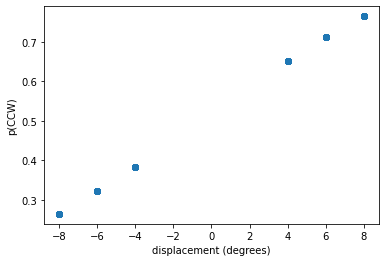

In [6]:
# predicted value for the model for each trial
yfit = res.fittedvalues

# plot it as displacement on the X axis, and predicted value (i.e. p(CCW)) on the y-axis
plt.plot(df['displacement'],yfit,'o');

# don't forget axes labels!
plt.xlabel('displacement (degrees)');
plt.ylabel('p(CCW)');

However, we would like to recover the full psychometric curve. That is, as in part A of the assignment, our statistical model can also predict the responses for many other displacements beyond the values that were tested. This is the predictive power of the model, what is exploited in machine learning. <br>
**Let's plot the fitted psychometric curve**, i.e. the prediction curve for a linearly spaced list of x's (probe-target distances) in the range between -40 and 40 degrees. The fitted model can give you the predicted y's for those x's with the function `res.predict` in the results `res` of our model. Notice that because we defined our model with a formula, `predict` needs to get as argument also a Pandas DataFrame with a column *'displacement'* that contains the new *x* values on which we want to get predictions.

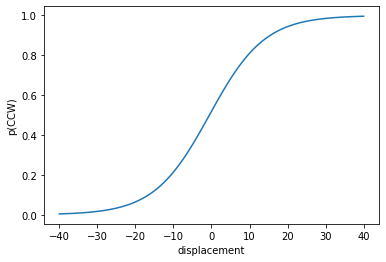

In [7]:
# array of linearly space values between -40 and 40 degrees
myx = np.linspace(-40,40,100)

# create a new dataframe of synthetic data with these displacements
df_synthetic = pd.DataFrame({'displacement': myx})

# use the fitted statistical model to compute p(CCW) for each value in this dataframe
yfit=res.predict(df_synthetic)

# plot the psychometric curve
plt.plot(myx,yfit,'-');

# don't forget axes labels!
plt.xlabel('displacement');
plt.ylabel('p(CCW)');

To check how well the model fits the data, we can now plot on top of this prediction the percent of experimental responses for each possible distance between probe and target. 
In the previous assignment, we saw how we could plot the psychometric curve for experimental data by looking at the proportion of CCW responses separately for each level of displacement. Now we're going to exploit the full potental of dataframes by computing and plotting this psychometric curve in a single line (see below)! All the operations are computed sequentially in this line: grouping by level of displacement, selecting the response, average (and computing standard error of the mean), plotting.

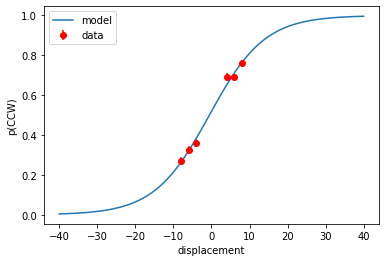

In [8]:
# COPY CODE HERE

# array of linearly space values between -40 and 40 degrees
myx = np.linspace(-40,40,100)

# use the fitted statistical model to compute p(CCW) for each value of the displacement
yfit=res.predict(pd.DataFrame({'displacement': myx}))

# plot the psychometric curve
plt.plot(myx,yfit,'-');

# don't forget axes labels!
plt.xlabel('displacement (degrees)');
plt.ylabel('p(CCW)');

# now adding psychometric curve from participants (in one line!!!)
df.groupby('displacement').response.agg(('mean','sem')).plot(yerr='sem', fmt = 'ro', ax=plt.gca());

# add legend
plt.legend(('model','data'));

**Does the model provide a good fit?**

This graph shows that our logistic fit to the behavioral data is very good and has captured fairly well the behavior of our participants, or at least how their choices depend on the diplacement of the probe w.r.t the target.

## 2 Logistic regression with multiple factors
### 2.1 With two factors
Let us now include one further predictor, the distance between the target and the nearest non-target stimulus. This now goes in the direction of testing our hypothesis that non-target items kept in memory attract the memory of the target (as we tested in assignment 1).

**Run again the logistic regression model adding the distance of the nearest distractor as a regressor.**


In [9]:
#Compute the distance between the distractor and the target and add as a new column to the dataframe:
df['dist_distractor'] = circdist_deg( df['target'] , df['near'] )

# we now run the GLM with two predictors, displacement and dist_distractor
mod = smf.glm(formula= 'response ~ displacement + dist_distractor' , data=df,family=sm.families.Binomial())
res = mod.fit()

# print p-values for each predictor (check res.pvalues)
print(res.summary())
print("p-value for the displacement predictor: p=" + str(res.pvalues[1]))
print("p-value for the dist_distractor predictor: p=" + str(res.pvalues[2]))

                 Generalized Linear Model Regression Results                  
Dep. Variable:               response   No. Observations:                 3530
Model:                            GLM   Df Residuals:                     3527
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2154.0
Date:                Thu, 09 Feb 2023   Deviance:                       4307.9
Time:                        11:51:28   Pearson chi2:                 3.53e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0763      0.037     

In [10]:
assert np.round(np.abs(10000*res.params[2]))==3

**Does this additional predictor contributes significantly to the model description? How do you interpret this?**

### 2.2 With three factors
Including the factor of interest "distance from nearest non-target to target stimulus" did not improve our model much, and the p-value for the coefficient of this factor is >>0.05, indicating that we cannot reject the null-hypothesis that this coefficient is zero. This is disappointing because the point of our experiment was to identify a biasing effect of simultaneous memories in reports in spatial working memory, but this model does not include all the detail about our experiment so we should go ahead and add all the other factors that intervened in our design and might interact with the putative biasing effect.

**We will now include one more predictor, the delay duration of each individual trial.  Run again the generalized linear model with this new regressor.**


In [11]:
# we include the predictor *delay* in the GLM
mod = smf.glm(formula= 'response ~ displacement + delay + dist_distractor'  , data=df,family=sm.families.Binomial())
res = mod.fit()

print(res.summary())
print("p-value for the displacement predictor: p=" + str(res.pvalues[1]))
print("p-value for the dist_distractor predictor: p=" + str(res.pvalues[2]))
print("p-value for the delay predictor: p=" + str(res.pvalues[3]))

                 Generalized Linear Model Regression Results                  
Dep. Variable:               response   No. Observations:                 3530
Model:                            GLM   Df Residuals:                     3526
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2153.8
Date:                Thu, 09 Feb 2023   Deviance:                       4307.6
Time:                        11:51:28   Pearson chi2:                 3.53e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0996      0.055     

In [12]:
assert np.round(np.abs(10000*res.params[2]))==4

 **Does this last factor contributes significantly to the model description? What is your interpretation?**

Adding also the factor "delay" again only increased marginally the likelihood of our model and did not do this with a coefficient for *'delay'* significantly different from 0. However, if we think carefully about our intentions with this experiment, the crucial point is an interaction of interest that we have not yet included in the model.

### 2.3 Logistic regression including interaction of variables!

Now notice that the hypothesis of our experiment was that there would be an attraction of behavioral responses toward near non-target memories, but specifically when there was a delay between cue and probe (i.e. this was a memory effect, as opposed to a perceptual effect). None of our analyses so far addressed this “specifically”, “only”, “here but not there” question. We need an interaction! Which one? <br>
**Run the generalized linear model again adding the appropriate interaction terms and check if this interaction factor contributes significantly to the model description. What is your interpretation now?**

In [13]:
#include the interaction of interest
mod = smf.glm(formula= 'response ~ displacement + dist_distractor*delay'  , data=df,family=sm.families.Binomial())
res = mod.fit()


print(res.summary())
print("p-value for the probe_target factor: p=" + str(res.pvalues[1]))
print("p-value for the dist_NT factor: p=" + str(res.pvalues[2]))
print("p-value for the delay factor: p=" + str(res.pvalues[3]))
print("p-value for the interaction dist_NT*delay: p=" + str(res.pvalues[4]))

                 Generalized Linear Model Regression Results                  
Dep. Variable:               response   No. Observations:                 3530
Model:                            GLM   Df Residuals:                     3525
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2152.2
Date:                Thu, 09 Feb 2023   Deviance:                       4304.5
Time:                        11:51:28   Pearson chi2:                 3.54e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.09

In [14]:
assert np.round(np.abs(10000*res.params[4]))==7

Now we obtain a marginally significant interaction! When we have interactions, main effects are not easily interpretable since we can have effects for one predictor that go in different directions when considering different levels of another predictor, and this could yield vanishing main effects.

### 2.4 Understanding significant interactions
Significant interactions can be analyzed by separating by one of the implicated predictors. <br>
**Run the model without the interaction factor and without the delay factor (i.e. the model of 2.1) separately on trials with delay 0.1 second (*perceptual trials*), and on trials with delays 1 and 3 seconds (*memory trials*)**. What do you see? 

Hint: Take special attention not only to the significance of the regressors, but also to the value of the fitted beta parameter (in particular, the sign). 


In [15]:
print('LOGISTIC REGRESSION IN PERCEPTUAL TRIALS')

#we build a boolean to select trials with delay 0.1 
bool_percept = df.delay<0.5 

# we run now the two-regressor model for this subset of data, including only perceptual trials
mod = smf.glm(formula='response ~ displacement + dist_distractor', data= df[bool_percept] ,family=sm.families.Binomial())
res = mod.fit()  # fit the model

# print summary
print(res.summary())
print("parameter for the dist_distractor predictor: beta = " + str(res.params[2]))
print("p-value for the dist_distractor predictor: p=" + str(res.pvalues[2]))

########

print('')
print('')
print('')

print('LOGISTIC REGRESSION IN MEMORY TRIALS')

#we build a boolean to select trials with delay 1 or 3 seconds
bool_mem = df.delay>0.5 

# we run now the two-regressor model for this subset of data, including only perceptual trials
mod = smf.glm(formula='response ~ displacement + dist_distractor', data= df[bool_mem] ,family=sm.families.Binomial())
res = mod.fit()


print(res.summary())
print("parameter for the dist_distractor predictor: beta = " + str(res.params[2]))
print("p-value for the dist_distractor predictor: p=" + str(res.pvalues[2]))



Logistic regression at short Delay
                 Generalized Linear Model Regression Results                  
Dep. Variable:               response   No. Observations:                 1176
Model:                            GLM   Df Residuals:                     1173
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -723.11
Date:                Thu, 09 Feb 2023   Deviance:                       1446.2
Time:                        11:51:28   Pearson chi2:                 1.18e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Interce

In [16]:
assert np.round(np.abs(10000*res.params[2]))==12

Now that we split the data between perceptual trials and memory trials (i.e. short and long delays), we obtain that the two-regressor model now shows a significant main effect for the *dist_distractor* factor, in memory trials only. This was previously non-significant in the full model. If we look closely, we will see that the value of the coefficient for *dist_distractor* is now positive for short delays (0.0013)  and negative for long delays (-0.0012). This is indicating that the bias induced by non-targets may be different for each of these 2 conditions: repulsive for short delays (or non-significant), and attractive for long delays. This is the interaction that we found significant and this would explain that when we run the full model the main factor *dist_distractor* has a vanishing coefficient because attractions and repulsions form the different delay conditions cancel one another.

We validate this intuition by plotting the data graphically in a way that will reveal our interpretation. This step is crucial to consolidate our interpretation.

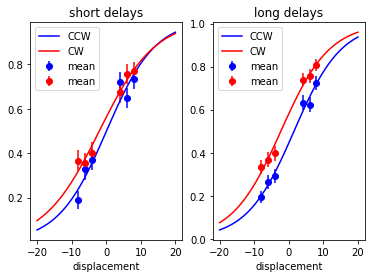

In [17]:
# add boolean vector that is true for memory trials only (i.e. delay = 1 or 3 seconds)
df['memory'] = df['delay']>0.5 #this dichotomizes the delay: 0=no-delay trial, 1=delay trial

# create a subplot to the left
plt.subplot(1,2,1)

# 1. FIRST FIT AND PLOT FOR PERPCETUAL TRIALS WITH CCW DISTRACTORS

# boolean that is true for short delay trials with CCW distractors
bool_sel = ~df['memory'] & (df['dist_distractor']>0)

# fit single logistic regression (section 1) on these trials only
mod = smf.glm(formula='response ~ displacement', data=df[bool_sel],family=sm.families.Binomial())
res = mod.fit()

# define 100 angle points linearly spaced between -20 and 20 degrees
myx = np.linspace(-20,20,100)

# compute predicted value for each of these values
yfit=res.predict(pd.DataFrame({'displacement': myx}))

# plot fitted psychometric functions (in blue)
plt.plot(myx,yfit,'b-', label="CCW")

#now this adds the psychometric curve for experimental data (in blue)
df[bool_sel].groupby('displacement').response.agg(('mean','sem')).plot(yerr='sem', fmt = 'bo', ax=plt.gca(), legend=False);

# NOW REPEAT THE SAME FOR SHORT DELAYS TRIALS WITH CW DISTRACTOR

# we fit and plot then short delays for CW trials
bool_sel = ~df['memory'] & (df['dist_distractor']<0)
mod = smf.glm(formula='response ~ displacement', data=df[bool_sel],family=sm.families.Binomial())
res = mod.fit()

yfit=res.predict(pd.DataFrame({'displacement': myx}))
plt.plot(myx,yfit,'r-', label="CW") #(in red)

#now this adds the psychometric curve for experimental data
df[bool_sel].groupby('displacement').response.agg(('mean','sem')).plot(yerr='sem', fmt = 'ro', ax=plt.gca(), legend=False);

plt.legend(('CCW distractor','CW distractor'))
plt.title('short delays')

###################### ADD NEW SUBPLOT
plt.subplot(1,2,2)

# REPEAT THE SAME FOR MEMORY TRIALS (FIRST MEMORY TRIALS WITH CCW DISTRACTOR, THEN MEMORY TRIALS WITH CW DISTRACTOR)

# we fit and plot long delays for CCW trials (SAME AS ABOVE BUT FOR MEM, CCW TRIALS)
bool_sel = df['memory'] & (df['dist_distractor']>0)
mod = smf.glm(formula='response ~ displacement', data=df[bool_sel],family=sm.families.Binomial())
res = mod.fit()

yfit=res.predict(pd.DataFrame({'displacement': myx}))
plt.plot(myx,yfit,'b-', label="CCW")

#now this adds the psychometric curve for experimental data
df[bool_sel].groupby('displacement').response.agg(('mean','sem')).plot(yerr='sem', fmt = 'bo', ax=plt.gca());

# we fit and plot then long delays for CW trials (SAME AS ABOVE BUT FOR MEM, CW TRIALS)
bool_sel = df['memory'] & (df['dist_distractor']<0)
mod = smf.glm(formula='response ~ displacement', data=df[bool_sel],family=sm.families.Binomial())
res = mod.fit()

yfit=res.predict(pd.DataFrame({'displacement': myx}))
plt.plot(myx,yfit,'r-', label="CW")

#now this adds the psychometric curve for experimental data
df[bool_sel].groupby('displacement').response.agg(('mean','sem')).plot(yerr='sem', fmt = 'ro', ax=plt.gca());

plt.legend(('CCW distractor','CW distractor'))
plt.title('long delays');

#### OPTIONAL: 
(*In the cell above we repeated a lot of code. We could improve our Notebook by defining a function that plots one curve and data points, given the model and the original data, and then call this function 4 times as you select the various subplots. Go ahead and try this, if you like*)

In [18]:
# Function that takes two arguments (a dataframe and a color, and plot the fitting psychometric curve with experimental datapoints on top)
def plotcurve(df, color):
    mod = smf.glm(formula='response ~ displacement', data=df, family=sm.families.Binomial())
    res = mod.fit()
    
    myx = np.linspace(-20,20,100)
    yfit=res.predict(pd.DataFrame({'displacement': myx})) #yfit = res.predict(exog={'probe_target':myx})
    plt.plot(myx,yfit,'-', color=color)
    
    df.groupby('displacement').response.agg(('mean','sem')).plot(yerr='sem', color=color, fmt = 'o', ax=plt.gca());

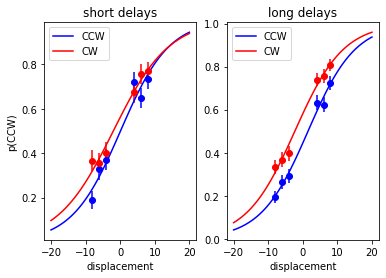

In [19]:
plt.subplot(1,2,1)

# we fit and plot first short delays for CCW trials
bool_sel = ~df['memory'] & (df['dist_distractor']>0)
plotcurve(df[bool_sel],'b')

bool_sel = ~df['memory'] & (df['dist_distractor']<0)
plotcurve(df[bool_sel],'r')

plt.legend(('CCW distractor','CW distractor'))
plt.title('short delays')
plt.ylabel('p(CCW)')

plt.subplot(1,2,2)

# we fit and plot long delays for CCW trials (SAME AS ABOVE BUT FOR MEM, CCW TRIALS)
bool_sel = df['memory'] & (df['dist_distractor']>0)
plotcurve(df[bool_sel],'b')
bool_sel = df['memory'] & (df['dist_distractor']<0)
plotcurve(df[bool_sel],'r')

plt.legend(('CCW distractor','CW distractor'))
plt.title('long delays');

## 2. Population analysis
### 2.1 Adding participant as categorical variable

In assignment 1 (linear regression), we ran a regression analysis on the data collapsing together data from all subjects and we then went on to run a regression analysis incorporating subjects as factors. We now want to incorporate the subject factor into our analysis, but notice that now this factor is categorical, not parametric as all other factors previously. In regression models, categorical predictors need special treatment: we use *C(factor)* to specify that *factor* is categorical. 

Run the **logistic regression model of 2.3 adding subject as an extra regressor**. 

In [20]:
# define model adding one intercept per subject
mod = smf.glm(formula= 'response ~ displacement + dist_distractor*delay + C(subject)' , data=df,family=sm.families.Binomial())
res = mod.fit()

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               response   No. Observations:                 3530
Model:                            GLM   Df Residuals:                     3518
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2147.1
Date:                Thu, 09 Feb 2023   Deviance:                       4294.2
Time:                        11:51:29   Pearson chi2:                 3.53e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.29

In [21]:
assert np.round(np.abs(1000*res.params[5]))==327

**How do you interpret the weights for each subject?** 

Each weight corresponds to a shift in the proportion of CCW responses specific to that subject, i.e. it represents the bias towards CCW responses for each subject. Note that there is no weight for subject 1, which is the reference subject. We always need a reference value for categorical regressors (to avoid colinearity). The bias of subject 1 is given by the intercept. So the bias for other subjects is actually the intercept PLUS their subject-specific weight.

**Does the fit improve?**

The log-likelihood of the model increased from -2152 to -2147 so there's a slight improvement in the fit.

### 3.2 Generalized linear mixed model (GLMM)
Here, we treated participants as fixed effects of our design, and this is good to make inferences about our sample population. However, to make more general inferences on the larger population that our sample represents, we should treat the subject factor as a random effect. This would then correspond to a Generalized Linear Mixed Model (GLMM). The terms *mixed* reflects the fact that the model includes both *fixed effects* (effects that are stable in the population, generally the ones we're interested in) and *random effects* (effects that vary between individuals). GLMMs are advanced regression methods implemented in the *lmer* function from the *pymer4* package. However there are many more packages for running these models in R, and here we'll see how to run R from Python. You can learn about this on your own, it is not part of the assignment, but you can play below to try to run such a model on this data (this is what was done in the orginal article by Almeida et al 2015).

In [22]:
# WARNING: THIS TAKES ABOUT 3~5 minutes (and will output a lot of text)
# Install R and Rpy2
!apt-get install r-base
#!pip install -q rpy2
!pip install rpy2==3.5.1

# Install LMER packages (for R)
packnames = ('lme4', 'lmerTest', 'emmeans')
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages(StrVector(packnames))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
r-base is already the newest version (4.2.2.20221110-1.2004.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached rpy2-3.5.1-cp38-cp38-linux_x86_64.whl
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.5
    Uninstalling rpy2-3.5.5:
      Successfully uninstalled rpy2-3.5.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymer4 0.8.0 requires rpy2>=3.5.3, but you have rpy2 3.5.1 which is incompatible.


(as ‘lib’ is unspecified)

















	‘/tmp/Rtmp5DH4mm/downloaded_packages’



<rpy2.rinterface_lib.sexp.NULLType object at 0x7f6a64eb2d00> [RTYPES.NILSXP]

In [23]:
# use R packages in python code. You have to have R installed, and the specific packages also need to be installed in R
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

In [24]:
# load packages in R (actually we probably don't use all of them)
base     = importr('base')
stats    = importr('stats')
lme4     = importr('lme4')
scales   = importr('scales')
lmerTest = importr('lmerTest')

# create R dataframe for mixed models from our Python dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  ro.globalenv['rdat'] = ro.conversion.py2rpy(df)

In [25]:
# define and fit the model in R. The command in R is placed in ro.r function: r0.r('Rcommand')
m0 = ro.r('glmm = lmer(response ~ displacement + dist_distractor*memory + (1|subject), data=rdat)')

# print model summary
print(lmerTest.summary_lmerModLmerTest(m0))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: response ~ displacement + dist_distractor * memory + (1 | subject)
   Data: rdat

REML criterion at convergence: 4558.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8129 -0.7690  0.4461  0.7435  1.7289 

Random effects:
 Groups   Name        Variance  Std.Dev.
 subject  (Intercept) 0.0002226 0.01492 
 Residual             0.2097119 0.45794 
Number of obs: 3530, groups:  subject, 8

Fixed effects:
                             Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                 5.244e-01  1.436e-02  3.925e+01  36.508   <2e-16
displacement                3.192e-02  1.236e-03  3.518e+03  25.817   <2e-16
dist_distractor             2.817e-04  1.800e-04  3.523e+03   1.565   0.1177
memoryTRUE                 -1.294e-02  1.636e-02  3.518e+03  -0.791   0.4289
dist_distractor:memoryTRUE -5.353e-04  2.215e-04  3.524e+03  -2.416   0.0157
                        

This model only considered subject-to-subject variability coming from systematic CW/CCW biases in the responses (the term `(1|subj)` considers variability in the intercept, which determines CW/CCW biases in the responses of individual participants). However, this is maybe not the most intuitive way that we expect our participants to differ from one another. It makes maybe more sense to think that what will really be different from subject to subject is the sensibility in detecting small displacements of the probe. Some people will be very sensitive to small displacements, while others will need longer distances to perceive clearly the shift. In other words, some subjects will discriminate better than others. The sensibility is the maximal slope of the psychometric function, and it is directly related to the logistic regression parameter for the `displacement` variable. Here is how would you enter this subject-to-subject variability in the model.

In [26]:
m0 = ro.r('glmm = lmer(response ~ displacement + dist_distractor*memory + (1+displacement|subject), data=rdat)')
print(lmerTest.summary_lmerModLmerTest(m0))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
response ~ displacement + dist_distractor * memory + (1 + displacement |  
    subject)
   Data: rdat

REML criterion at convergence: 4499.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0528 -0.8025  0.2759  0.7625  1.9151 

Random effects:
 Groups   Name         Variance  Std.Dev.  Corr 
 subject  (Intercept)  7.788e-07 0.0008825      
          displacement 1.338e-04 0.0115652 -0.99
 Residual              2.054e-01 0.4531813      
Number of obs: 3530, groups:  subject, 8

Fixed effects:
                             Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                 5.243e-01  1.322e-02  2.885e+03  39.648  < 2e-16
displacement                3.186e-02  4.268e-03  7.008e+00   7.465 0.000141
dist_distractor             2.628e-04  1.784e-04  3.520e+03   1.473 0.140798
memoryTRUE                 -1.271e-02  1.619e-02  3.518e+03  -0.785 0.432412
dist_d

This is the proper way of running the analysis. The random factor considers variability between participants in mean responses and in the sensitivity to `probe_target`, and establishes the pairing between data collected for each participant. This analysis reveals that the `dist_NT:delay` interaction is significant, with `p=0.012`.

An important element that has been added here as well is the dichotomization of the delays. Instead of asking effects to be 3 times stronger in 3s-delay trials compared to 1s-delay trials, we just focus on differences between delay trials (either 1s or 3s trials, both with score 1) and no-delay trials (0.1s delay, now scored 0). You can try and see that this also improves the significance of the interaction term in the previous analyses.

In [27]:
m0 = ro.r('glmm = lmer(response ~ displacement*dist_distractor*memory + (1+displacement|subject), data=rdat)')
print(lmerTest.summary_lmerModLmerTest(m0))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
response ~ displacement * dist_distractor * memory + (1 + displacement |  
    subject)
   Data: rdat

REML criterion at convergence: 4546.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0892 -0.8060  0.2849  0.7659  1.9277 

Random effects:
 Groups   Name         Variance  Std.Dev. Corr 
 subject  (Intercept)  0.0002227 0.01492       
          displacement 0.0001329 0.01153  -0.05
 Residual              0.2052491 0.45304       
Number of obs: 3530, groups:  subject, 8

Fixed effects:
                                          Estimate Std. Error         df
(Intercept)                              5.237e-01  1.424e-02  3.903e+01
displacement                             3.043e-02  4.594e-03  9.504e+00
dist_distractor                          2.816e-04  1.788e-04  3.515e+03
memoryTRUE                              -1.210e-02  1.619e-02  3.508e+03
displacement:dist_distractor  